# Exploring Postmortem Patterns of Alcohol Consumption Nationally
- Final Project Plots for DS4200 Information Presentation and Visualization
- Northeastern University Spring 2024 Professor Xiaoyi Yang
- Authors: Ansley Cooper ‘25 & Shannen Espinosa ‘25
- Contact: cooper.ans@northeastern.edu & espinosa.s@northeastern.edu

---

Welcome to the "raw data" from our website: https://shannenespinosa.github.io/ds4200-final/

Here, we are analyzing the Health.gov dataset on [Alcohol-Related Disease Impact](https://healthdata.gov/dataset/Alcohol-Related-Disease-Impact-ARDI-Application-Al/8i56-u98i/about_data) across the United States. It contains 30 columns and 62,505 rows of data. The rows are data reports between 2015 and 2019 across ages and sexes for deaths attributable to alcohol. It contains estimates of alcohol-related disease impacts across the United States, noting causes of death and years of potential life lost. Our analyses were inspired by the [CDC's Application on Alcohol-Related Disease Impact](https://nccd.cdc.gov/DPH_ARDI/default/default.aspx) and the [CDC's Data on Excessive Drinking](https://www.cdc.gov/alcohol/data-stats.htm).

---

## Table of Contents
- Figure 1: Geospatial Maps (Interactive)
  - 1A: Number of Alcohol Related Deaths per 1000 People by Age
  - 1B: Number of Alcohol Related Deaths per 1000 People by Cause of Death
- Figure 2: Heatmaps (Static)
  - 2A: Number of Alcohol Related Deaths per 1000 People by Age
  - 2B: Number of Alcohol Related Deaths per 1000 People by Cause of Death
- Figure 3: Bar Charts (Static and Interactive)
  - 3A: Fatality Frequencies of Causes of Death (Static)
  - 3B: Fatality Frequencies of Causes of Death by State (Interactive)
- Figure 4: Assessment of Fatalities by sex
  - 4A: D3 representation of moralities by sex donut plot (Interactive)
  - 4B: Follium geospatial representation of 

In [1]:
import pandas as pd
import geopandas as gpd
import altair as alt

In [2]:
alc_df = pd.read_csv('filtered_alc_mort.csv', index_col=0)
state = gpd.read_file("states/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp")
pop_df = pd.read_csv('nst-est2019-01.csv')

# Figure 1: Geospatial Maps (Interactive)

In [3]:
states = alt.topo_feature(data.us_10m.url, 'states')

base = alt.Chart(states).mark_geoshape(
    fill='#EEE',
    stroke='white'
).properties(
    width=500,
    height=300
).project('albersUsa')

NameError: name 'data' is not defined

### Fig 1A: Number of Alcohol Related Deaths per 1000 People by Age

In [ ]:
alc_df["Fatalities"] = alc_df["Data_Value"].replace("-" , 0).fillna(0).astype(int)
alc_df_age = alc_df.groupby(by = ['LocationDesc', 'AgeGroup'], as_index= False).sum("Fatalities")
alc_df_age = alc_df_age.iloc[:, [0,1,4]]
alc_df_age = alc_df_age[alc_df_age["AgeGroup"] != "Under 21"]
alc_df_age = alc_df_age[~alc_df_age["LocationDesc"].isin(["District of Columbia", "United States"])]

full = pd.merge(state, alc_df_age, left_on='woe_name', right_on='LocationDesc', how='outer')
full.dropna(subset=['AgeGroup'], inplace=True)

pop_df['state'] = pop_df['state'].str.replace('.', '')

full = pd.merge(full, pop_df, left_on='woe_name', right_on='state', how='inner')
full = full[full['AgeGroup'] != 'Under 21']
full['per_capita'] = full['Fatalities'] / full['population '] * 1000

In [ ]:
category_dropdown = alt.binding_radio(options=list(set(full['AgeGroup'])))
selection = alt.selection_point(fields=['AgeGroup'], bind=category_dropdown, name='Select')

alcohol = alt.Chart(full).mark_geoshape().encode(
    color = 'per_capita:Q',
    tooltip=[
        alt.Tooltip('name:N', title='State'),
        alt.Tooltip('per_capita:Q', title='Number of Alchohol Related Deaths per 1000 People')
    ]
).add_params(
    selection
).transform_filter(
    selection
).properties(
    title="Figure 5.   Prevalence of Alcohol-Related Deaths by Age State-by-State"
)

age_map = base + alcohol

age_map.configure_title(anchor='start')

### Fig 1B: Number of Alcohol Related Deaths per 1000 People by Cause of Death

In [ ]:
alc_df_cause = alc_df.groupby(by=['LocationDesc', 'Cause_of_Death'], as_index=False).sum("Fatalities")

empty_data = [
    "Alcoholic myopathy", "Alcohol polyneuropathy", "Pancreatitis, chronic",
    "Alcohol-induced chronic pancreatitis", "Infant death, preterm birth", 
    "Fetus and newborn affected by maternal use of alcohol", "Fetal alcohol syndrome", 
    "Gastroesophageal hemorrhage", "Air-space transport", 
    "Water transport", "Chronic hepatitis", "Infant death, low birth weight", 
    "Suicide by and exposure to alcohol", "Portal hypertension", 
    "Occupational and machine injuries", "Alcoholic gastritis", 
    "Infant death, small for gestational age", "Gallbladder disease"
]

limited_data = [
    "Alcohol abuse", "Degeneration of nervous system due to alcohol",
    "Pancreatitis, acute", "Unprovoked seizures, epilepsy, or seizure disorder",
    "Alcohol cardiomyopathy", "Child maltreatment", "Pneumonia",
    "Other road vehicle crashes", "Firearm injuries", "Esophageal varices",
    "Alcoholic psychosis", "Hypothermia", "Alcohol-induced acute pancreatitis",
    "Motor vehicle nontraffic crashes", "Aspiration", "Cancer, pancreatic", "Cancer, stomach"
]

alc_df_cause = alc_df_cause[~alc_df_cause['Cause_of_Death'].isin(empty_data + limited_data)]

full = pd.merge(state, alc_df_cause, left_on='woe_name', right_on='LocationDesc', how='outer')
full.dropna(subset=['Cause_of_Death'], inplace=True)
pop_df = pd.read_csv('nst-est2019-01.csv')
pop_df['state'] = pop_df['state'].str.replace('.', '')
full = pd.merge(full, pop_df, left_on='woe_name', right_on='state', how='inner')
full['per_capita'] = full['Fatalities'] / full['population '] * 1000

In [ ]:
category_dropdown = alt.binding_radio(options=list(set(full['Cause_of_Death'])))
selection = alt.selection_point(fields=['Cause_of_Death'], bind=category_dropdown, name='Select')

cod_map = alt.Chart(full).mark_geoshape().encode(
    color='per_capita:Q',
    tooltip=[
        alt.Tooltip('name:N', title='State'),
        alt.Tooltip('per_capita:Q', title='Number of Alcohol Related Deaths per 1000 People')
    ]
).add_selection(
    selection
).transform_filter(
    selection
).properties(
    title="Figure 7.   Prevalence of Different Alcohol-Related Causes of Death State-by-State"
)

death_map = base + cod_map

death_map.configure_title(anchor='start')

In [ ]:
age_map.save("plots_html/age_map.html")
death_map.save("plots_html/death_map.html")

# Figure 2: Heatmaps (Static)

### Fig 2A: Number of Alcohol Related Deaths per 1000 People by Age

In [ ]:
alc_df_age = alc_df_age[alc_df_age["AgeGroup"] != "Overall"]

age_heatmap = alt.Chart(alc_df_age).mark_rect().encode(
    x='LocationDesc:N',
    y='AgeGroup:N',
    color=alt.Color('Fatalities:Q', scale=alt.Scale(scheme='reds')),
    tooltip=[
        alt.Tooltip('LocationDesc:N', title='State'),
        alt.Tooltip('AgeGroup:N', title='Age Group'),
        alt.Tooltip('Fatalities:Q', title='Number of Alcohol Related Deaths')
    ]
).properties(
    width=500,
    height=300,
    title="Figure 6.   Heatmap of Alcohol Related Deaths by Age Group and State"
).configure_title(anchor='start')

age_heatmap

### Fig 2B: Number of Alcohol Related Deaths per 1000 People by Cause of Death

In [ ]:
full = full[full['Cause_of_Death'] != 'Total for All Causes']

death_heatmap = alt.Chart(full).mark_rect().encode(
    x='name:N',
    y='Cause_of_Death:N',
    color=alt.Color('per_capita:Q', scale=alt.Scale(scheme='reds')),
    tooltip=[
        alt.Tooltip('name:N', title='State'),
        alt.Tooltip('Cause_of_Death:N', title='Cause of Death'),
        alt.Tooltip('per_capita:Q', title='Number of Alcohol Related Deaths per 1000 People')
    ]
).properties(
    width=500,
    height=300,
    title="Figure 8.   Heatmap of Alcohol Related Deaths by Cause of Death"
).configure_title(anchor='start')

death_heatmap

In [ ]:
age_heatmap.save("plots_html/age_heatmap.html")
death_heatmap.save("plots_html/death_heatmap.html")

# Figure 3: Bar Charts (Static and Interactive)

### Fig 3A: Fatality Frequencies of Causes of Death

In [ ]:
avg_cause_of_death_df = alc_df[['Cause_of_Death', 'Fatalities']]
avg_cause_of_death_df = avg_cause_of_death_df.groupby(by = 'Cause_of_Death', as_index= False).sum('Fatalities')
avg_cause_of_death_df = avg_cause_of_death_df[avg_cause_of_death_df['Cause_of_Death'] != 'Total for All Causes']

static_bar = alt.Chart(avg_cause_of_death_df).mark_bar().encode(
    x=alt.X('Cause_of_Death:N', sort='-y'),
    y='Fatalities:Q'
).properties(
    title="Figure 3.   Total Nationwide Fatality Frequencies of Alcohol-Related Causes of Death"
).configure_title(anchor='start')

static_bar

### Fig 3B: Fatality Frequencies of Causes of Death by State

In [ ]:
avg_cause_of_death_df_st = alc_df[['Cause_of_Death', 'Fatalities', 'LocationDesc']]
avg_cause_of_death_df_st = avg_cause_of_death_df_st.groupby(by = ['LocationDesc', 'Cause_of_Death'], as_index= False).sum('Fatalities')
avg_cause_of_death_df_st = avg_cause_of_death_df_st[avg_cause_of_death_df_st['Cause_of_Death'] != 'Total for All Causes']

category_dropdown = alt.binding_select(options= avg_cause_of_death_df_st['LocationDesc'].unique())
fat_selection = alt.selection_point(fields=['LocationDesc'], bind=category_dropdown, name='Select')

interactive_bar = alt.Chart(avg_cause_of_death_df_st).mark_bar().encode(
    x=alt.X('Cause_of_Death:N', sort='-y'),
    y='Fatalities:Q'
).add_params(
    fat_selection
).transform_filter(
    fat_selection
).properties(
    title="Figure 4.   State-based Fatality Frequencies of Alcohol-Related Causes of Death"
).configure_title(anchor='start')

interactive_bar

In [ ]:
static_bar.save("plots_html/static_bar.html")
interactive_bar.save("plots_html/interactive_bar.html")

# Figure 4b

In [92]:
alc_df["Fatalities"] = alc_df["Data_Value"].replace("-" , 0).fillna(0).astype(int)

alc_df = alc_df[~alc_df["LocationDesc"].isin(["District of Columbia", "United States"])]



alc_df['Data_Value'] = pd.to_numeric(alc_df['Data_Value'].replace('-', 0))
alc_df1 = alc_df[["LocationDesc", "Data_Value", "Sex"]]
alc_df1.columns = ['LocationDesc', 'Fatalities', 'Sex']
alc_df1 = alc_df1[alc_df1["Sex"] != 'Overall']
alc_df_sex = alc_df1.groupby(['LocationDesc', 'Sex'], as_index=False).sum()


alc_df_sex = alc_df_sex[alc_df_sex['LocationDesc'] != 'Alaska']
alc_df_sex = alc_df_sex[alc_df_sex['LocationDesc'] != 'Hawaii']

pop_df['state'] = pop_df['state'].str.replace('.', '')

full = pd.merge(alc_df_sex, pop_df, left_on='LocationDesc', right_on='state', how='inner')

full['per_capita'] = full['Fatalities'] / full['population '] * 1000



fem = full[full['Sex'] == 'Female'].copy()
fem_geo = gpd.GeoDataFrame(pd.merge(state, fem, left_on='woe_name', right_on='LocationDesc', how='inner'))
print(fem_geo.head())

male = full[full['Sex'] == 'Male'].copy()
male_geo = gpd.GeoDataFrame(pd.merge(state, male, left_on='woe_name', right_on='LocationDesc', how='inner'))


           featurecla  scalerank adm1_code  diss_me iso_3166_2  \
0  Admin-1 scale rank          2  USA-3514     3514      US-MN   
1  Admin-1 scale rank          2  USA-3515     3515      US-MT   
2  Admin-1 scale rank          2  USA-3516     3516      US-ND   
3  Admin-1 scale rank          2  USA-3518     3518      US-ID   
4  Admin-1 scale rank          2  USA-3519     3519      US-WA   

                                         wikipedia iso_a2  adm0_sr  \
0           http://en.wikipedia.org/wiki/Minnesota     US        1   
1             http://en.wikipedia.org/wiki/Montana     US        1   
2        http://en.wikipedia.org/wiki/North_Dakota     US        1   
3               http://en.wikipedia.org/wiki/Idaho     US        1   
4  http://en.wikipedia.org/wiki/Washington_(state)     US        6   

           name  name_alt  ... FCLASS_BD FCLASS_UA FCLASS_TLC  \
0     Minnesota  MN|Minn.  ...      None      None       None   
1       Montana  MT|Mont.  ...      None      None  

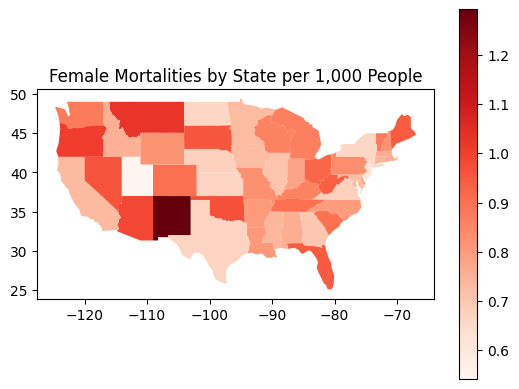

In [93]:
fem_geo.plot(column = 'per_capita', legend = True, cmap='Reds').set_title('Female Mortalities by State per 1,000 People')
plt.savefig('viz/female_chloro.jpg')

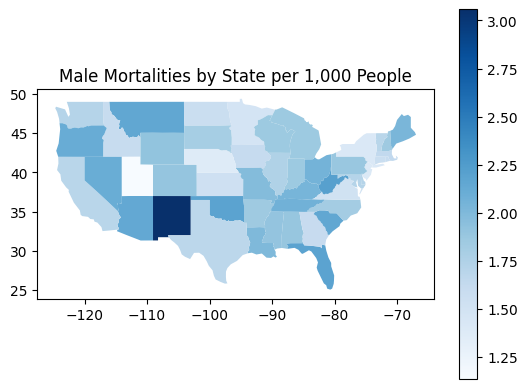

In [94]:
male_geo.plot(column = 'per_capita', legend = True, cmap='Blues').set_title('Male Mortalities by State per 1,000 People')
plt.savefig('viz/male_chloro.jpg')